# Chroma Vector Database Tutorial

빠른 이미지 검색을 위한 벡터 데이터베이스 튜토리얼

In [1]:
!pip install -q chromadb transformers==4.38.2

## Dataset

Food-11 데이터셋 중 evaluation 데이터 10장씩

https://www.kaggle.com/datasets/trolukovich/food11-image-dataset

In [ ]:
!wget -q https://github.com/kairess/toy-datasets/raw/master/Food-11.zip
!unzip -q Food-11.zip

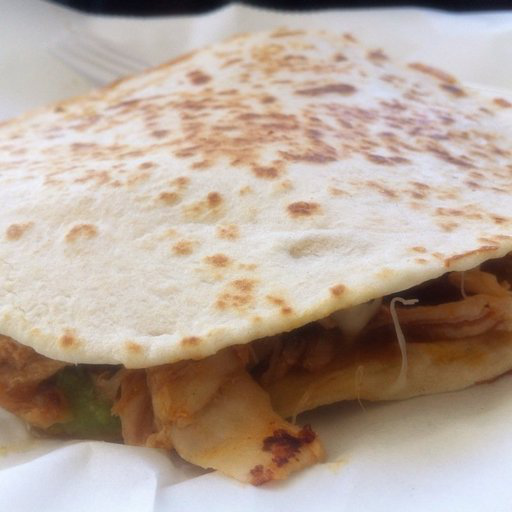

In [1]:
from PIL import Image

img = Image.open("Food-11/test/Bread/1.jpg")

img

## Image Vectorizer 모델 로드

https://huggingface.co/facebook/dino-vits16

In [ ]:
from transformers import ViTImageProcessor, ViTModel

feature_extractor = ViTImageProcessor.from_pretrained('facebook/dino-vits16')
model = ViTModel.from_pretrained('facebook/dino-vits16')

print("Models loaded!")

## 임베딩

In [ ]:
img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
outputs = model(**img_tensor)

embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()

embedding

array([-0.7699969 , -0.99916106,  0.8623158 , -0.8976303 ,  0.98617905,
       -0.94958615,  0.9605374 ,  0.7795165 ,  0.9943294 , -0.727654  ,
        0.7748134 ,  0.5368932 ,  0.9950716 ,  0.986502  , -0.93571985,
       -0.9806659 , -0.9993208 , -0.75395703, -0.99901897, -0.1137156 ,
       -0.12605351, -0.99501354, -0.88508016,  0.989024  ,  0.10828065,
       -0.31179172,  0.5446769 ,  0.9945255 , -0.03856469, -0.7603067 ,
        0.864652  , -0.9989481 , -0.02504171, -0.9915368 , -0.9896291 ,
        0.947635  ,  0.71757394,  0.0830933 ,  0.803349  ,  0.9969915 ,
        0.9924858 ,  0.9998136 ,  0.907744  ,  0.09489997, -0.9577912 ,
       -0.4971063 ,  0.4438852 , -0.33484548, -0.69613045, -0.99209905,
       -0.95473754,  0.52567065, -0.955391  , -0.8847614 , -0.92808366,
        0.9902545 , -0.9913402 ,  0.03765959,  0.99336445, -0.47425434,
        0.9670756 , -0.9271097 ,  0.25026652, -0.6343465 , -0.98491424,
        0.8726089 , -0.93420184,  0.6639755 , -0.86099917, -0.93

In [ ]:
embedding.shape

(384,)

## Chroma DB 시작

https://www.trychroma.com

In [ ]:
import chromadb

client = chromadb.Client()

collection = client.create_collection("foods")

## 모든 이미지 벡터화

In [ ]:
from glob import glob

img_list = sorted(glob("test/*/*.jpg"))

len(img_list)

110

In [ ]:
from tqdm import tqdm

embeddings = []
metadatas = []
ids = []

for i, img_path in enumerate(tqdm(img_list)):
    img = Image.open(img_path)
    cls = img_path.split("/")[1]

    img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
    outputs = model(**img_tensor)

    embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()
    embedding_to_list = embedding.tolist()

    embeddings.append(embedding_to_list)

    metadatas.append({
        "uri": img_path,
        "name": cls
    })

    ids.append(str(i))

print("Done!")

100%|██████████| 110/110 [00:01<00:00, 63.04it/s]

Done!


## 임베딩을 데이터베이스에 저장

In [ ]:
collection.add(
    embeddings=embeddings,
    metadatas=metadatas,
    ids=ids,
)

## Test1

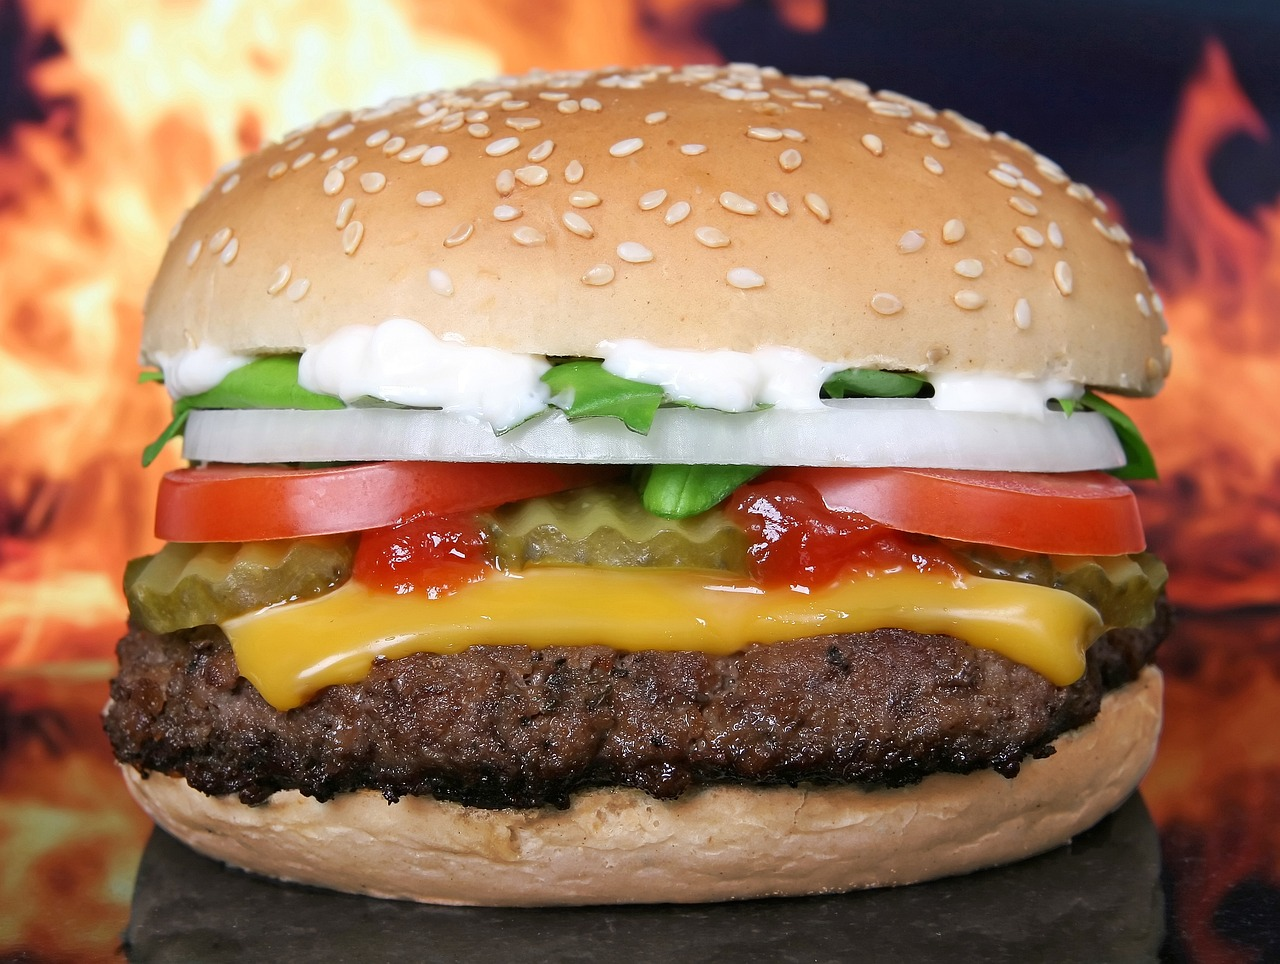

In [ ]:
import requests

test_img = Image.open(requests.get("https://cdn.pixabay.com/photo/2016/03/05/19/02/hamburger-1238246_1280.jpg", stream=True).raw).convert("RGB")

test_img

In [ ]:
test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
test_outputs = model(**test_img_tensor)

test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
test_embedding_list = test_embedding.tolist()

test_embedding.shape

(384,)

In [ ]:
query_result = collection.query(
    query_embeddings=[test_embedding_list],
    n_results=3,
)

query_result

{'ids': [['8', '2', '6']],
 'distances': [[138.837158203125, 259.7716064453125, 288.45538330078125]],
 'metadatas': [[{'name': 'Bread', 'uri': 'test/Bread/8.jpg'},
   {'name': 'Bread', 'uri': 'test/Bread/2.jpg'},
   {'name': 'Bread', 'uri': 'test/Bread/6.jpg'}]],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'data': None}

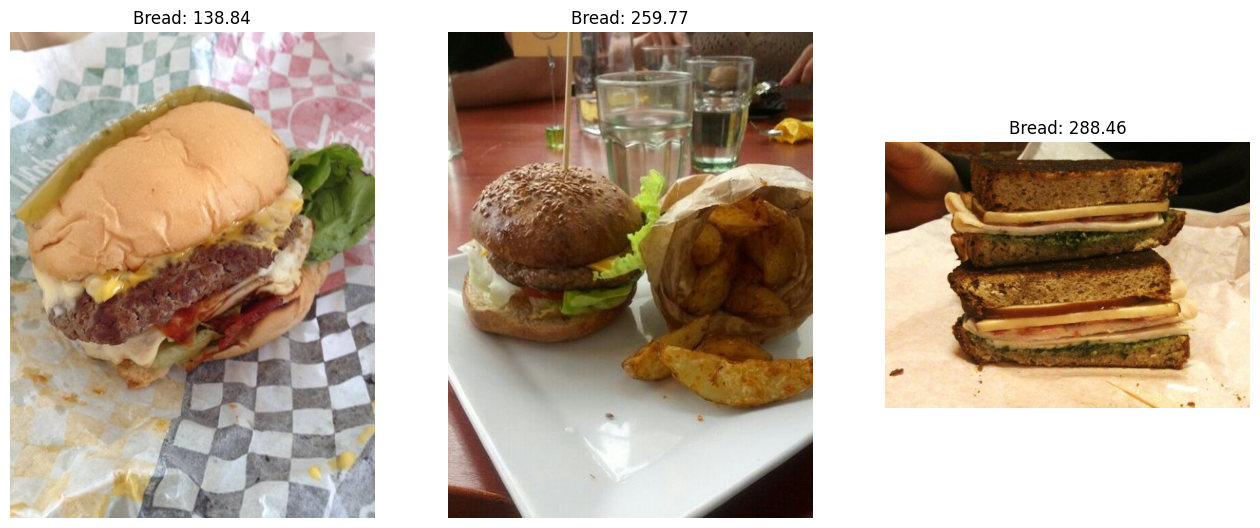

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 10))

for i, metadata in enumerate(query_result["metadatas"][0]):
    distance = query_result["distances"][0][i]

    axes[i].imshow(Image.open(metadata["uri"]))
    axes[i].set_title(f"{metadata['name']}: {distance:.2f}")
    axes[i].axis("off")

## 테스트를 위한 함수화

In [ ]:
def query(img_url, n_results=3):
    test_img = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

    test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
    test_outputs = model(**test_img_tensor)

    test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
    test_embedding_list = test_embedding.tolist()

    query_result = collection.query(
        query_embeddings=[test_embedding_list],
        n_results=n_results,
    )

    fig, axes = plt.subplots(1, 4, figsize=(16, 10))

    axes[0].imshow(test_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]

        axes[i+1].imshow(Image.open(metadata["uri"]))
        axes[i+1].set_title(f"{metadata['name']}: {distance:.2f}")
        axes[i+1].axis("off")

    return query_result

## Test2

{'ids': [['108', '57', '50']],
 'distances': [[260.45343017578125, 262.90789794921875, 278.54803466796875]],
 'metadatas': [[{'name': 'Vegetable-Fruit',
    'uri': 'test/Vegetable-Fruit/8.jpg'},
   {'name': 'Meat', 'uri': 'test/Meat/7.jpg'},
   {'name': 'Meat', 'uri': 'test/Meat/0.jpg'}]],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'data': None}

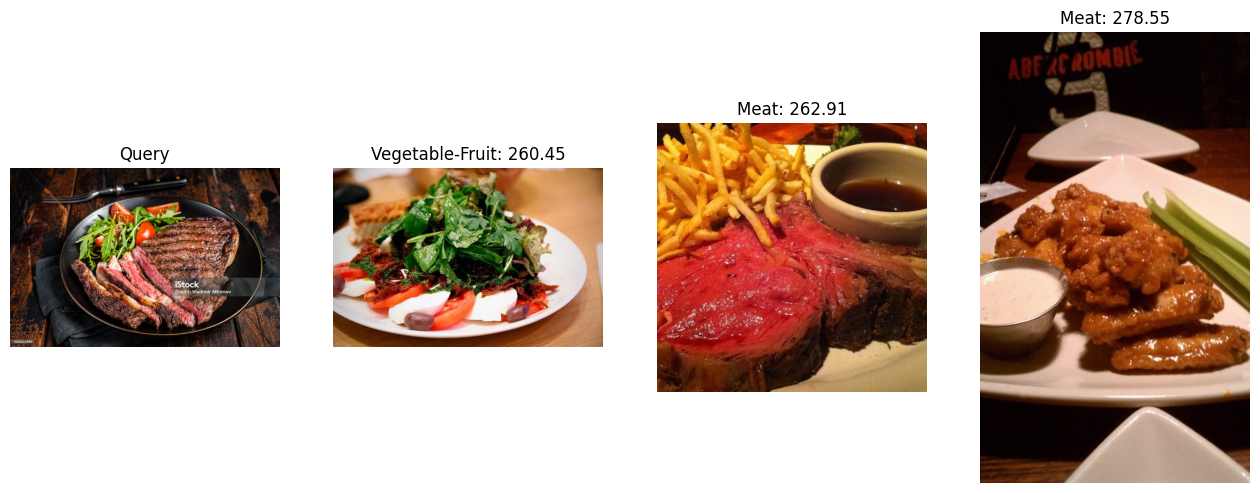

In [ ]:
query("https://media.istockphoto.com/id/1456242985/ko/%EC%82%AC%EC%A7%84/%EB%B0%94%EB%B2%A0%ED%81%90-%EA%B5%AC%EC%9D%B4%EC%99%80-%EC%96%87%EA%B2%8C-%EC%8D%AC-%EC%99%80%EA%B7%9C-%EA%B0%88%EB%B9%84%EB%88%88-%EC%87%A0%EA%B3%A0%EA%B8%B0-%EA%B3%A0%EA%B8%B0-%EC%8A%A4%ED%85%8C%EC%9D%B4%ED%81%AC%EB%A5%BC-%EC%A0%91%EC%8B%9C%EC%97%90-%EB%8B%B4%EC%95%98%EC%8A%B5%EB%8B%88%EB%8B%A4-%EC%96%B4%EB%91%90%EC%9A%B4-%EB%B0%B0%EA%B2%BD-%EC%83%81%EC%9C%84-%EB%B7%B0.jpg?s=2048x2048&w=is&k=20&c=HzOIn3NMB1GGE7mR0xYEdkjUPseIH5QvljOFAlYoIY0=")

{'ids': [['16', '47', '103']],
 'distances': [[306.00775146484375, 310.6091613769531, 313.662841796875]],
 'metadatas': [[{'name': 'Dairy product', 'uri': 'test/Dairy product/6.jpg'},
   {'name': 'Fried food', 'uri': 'test/Fried food/7.jpg'},
   {'name': 'Vegetable-Fruit', 'uri': 'test/Vegetable-Fruit/3.jpg'}]],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'data': None}

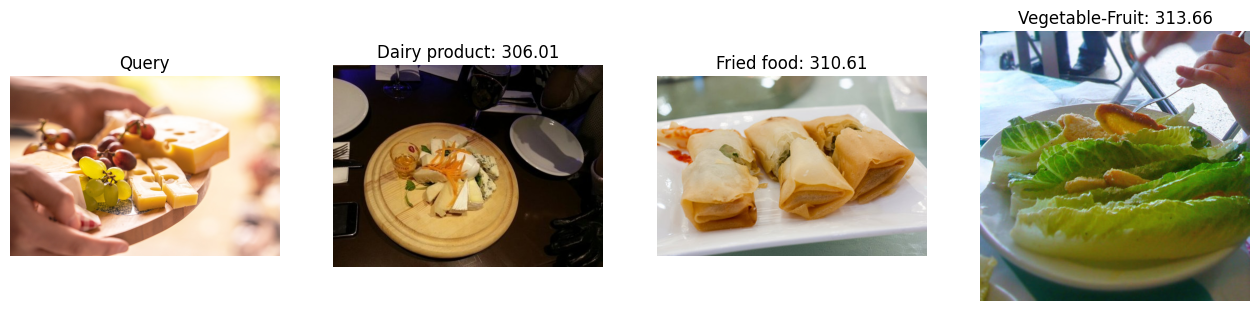

In [ ]:
query("https://cdn.pixabay.com/photo/2021/04/05/14/48/cheese-platter-6153716_1280.jpg")

{'ids': [['77', '75', '72']],
 'distances': [[212.24978637695312, 226.03094482421875, 232.6399383544922]],
 'metadatas': [[{'name': 'Rice', 'uri': 'test/Rice/7.jpg'},
   {'name': 'Rice', 'uri': 'test/Rice/5.jpg'},
   {'name': 'Rice', 'uri': 'test/Rice/2.jpg'}]],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'data': None}

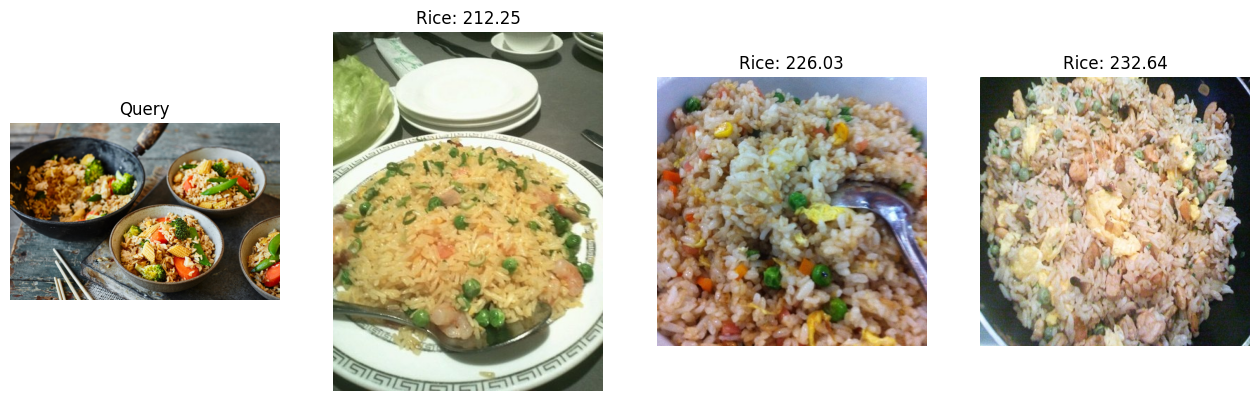

In [ ]:
query("https://i.imgur.com/WlLv0i9.png")